In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import least_squares

In [2]:
def average_rows(x,nblock=100):
    nr=x.shape[0]//nblock
    nc=x.shape[1]
    y=np.zeros((nr,nc),dtype=x.dtype)
    for i in range(nr):
        y[i,:]=np.mean(x[i*nblock:(i+1)*nblock],axis=0)
    return y

In [4]:
def get_coarse_xcorr(f1,f2,chans=None):
    """ Get coarse xcorr of each channel of two channelized timestreams.
    The xcorr is 0-padded, so length of output is twice the original length (shape[0]).
    
    Parameters
    ----------
    f1, f2 : ndarray of complex64
        First and second timestreams. Both n_spectrum x n_channel complex array.
    chans: tuple of int
        Channels (columns) of f1 and f2 that should be correlated.
    
    Returns
    -------
    ndarray of complex128
        xcorr of each channel's timestream. 2*n_spectrum x n_channel complex array.
    """
    Nsmall=f1.shape[0]
    print("Shape of passed channelized timestream =", f1.shape)
    if chans is None:
        chans = np.arange(f1.shape[1])
    xcorr=np.zeros((len(chans),2*Nsmall),dtype='complex128')
    win=np.hamming(2*Nsmall)
    wt = np.zeros(2*Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt)*np.conj(np.fft.rfft(wt)))
    print(n_avg)
    for i,chan in enumerate(chans):
        print("processing chan", chan)
        xcorr[i, :] = np.fft.ifft(
                        np.fft.fft(np.hstack([f1[:, chan].flatten(), np.zeros(Nsmall, dtype="complex128")]))
                        * np.conj(
                            np.fft.fft(np.hstack([f2[:, chan].flatten(), np.zeros(Nsmall, dtype="complex128")]))
                        )
                    )
        xcorr[i, :]=xcorr[i, :]/n_avg
    print(xcorr.shape)
    return np.ma.masked_invalid(xcorr)

@nb.njit(parallel=True,cache=True)
def make_complex(cmpl,mag,phase):
    N=cmpl.shape[0]
    for i in nb.prange(0,N):
        cmpl[i] = mag[i]*np.exp(1J*phase[i])

def get_interp_xcorr(coarse_xcorr, freq, sample_no, coarse_sample_no, offset, osamp=1):
    print("coarse shape", coarse_xcorr.shape)
    t1=time.time()
    final_xcorr_cwave = np.empty((coarse_xcorr.shape[0]-1)*8192*osamp,dtype='complex128')
    print("Total upsampled timestream samples in this coarse chunk =",sample_no.shape)
    t2=time.time()
    print("generation",t2-t1)
    sample_no2 = sample_no + offset
    t1=time.time()
    uph=np.unwrap(np.angle(coarse_xcorr))
    t2=time.time()
    print("unwrap",t2-t1)
    newphase=2*np.pi*freq*np.arange(0,coarse_xcorr.shape[0])+uph
    t1=time.time()
    newphase=np.interp(sample_no,coarse_sample_no,newphase)
    t2=time.time()
    print("interp", t2-t1)
    t1=time.time()
    cs=CubicSpline(coarse_sample_no,np.abs(coarse_xcorr))
    t2=time.time()
    print("CS gen", t2-t1)
    t1=time.time()
    newmag=cs(sample_no2)
    t2=time.time()
    print("cs eval",t2-t1)
    t1=time.time()
    
    t1=time.time()
    make_complex(final_xcorr_cwave,newmag,newphase)
    t2=time.time()
    print("make complex",t2-t1)
    # newmag = np.interp(x,np.arange(0,len(y))*4096,np.abs(c1full))
    return final_xcorr_cwave

NameError: name 'nb' is not defined

In [3]:
with np.load("../spectra_1830_1840_4096.npz") as f:
    spec1=f['spectra1']
    spec2=f['spectra2']
    delays=f['delays']

In [5]:
spec1.shape, spec2.shape

((500000, 10), (500000, 10))

-0.006248835644907544 -43.75472199466627


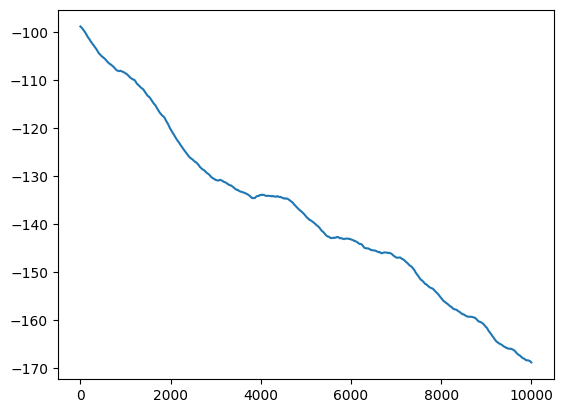

In [ ]:
st=10000
en=20000
plt.plot(delays[st:en])
m,c=np.polyfit(np.arange(st,en),delays[st:en],1)
# m,c=np.polyfit(np.arange(0,en-st),delays[st:en]-delays[st],1)
print(m,c)
# plt.xlim(20000,50000)

In [29]:
def newton(xc,alpha,chan,scale=0.1):
    c=2*np.pi*chan/4096
    N=len(xc)
    n=np.arange(N)
    xc_phased = xc*np.exp(1j*c*n*alpha)
    S0conj=np.conj(np.mean(xc_phased))
    S1=np.mean(xc_phased*n*c)
    S2=np.mean(xc_phased*n**2*c**2)
    df=np.imag(S0conj*S1)
    ddf=np.real(S0conj*S2) - np.abs(S1)**2
    alpha2 = alpha - scale*df/ddf
    print(f"old alpha {alpha:5.3e}, df {df:5.3e}, ddf {ddf:5.3e}, step size {df/ddf:5.3e} new alpha {alpha2:5.3e} ")
    return alpha2


In [44]:
def objective_func(xc,alpha,chan):
    c=2*np.pi*chan/4096
    N=len(xc)
    n=np.arange(N)
    xc_phased = xc*np.exp(1j*c*n*alpha)
    return np.abs(np.mean(xc_phased))**2

In [48]:
y1=spec1[st:en,4]
y2=spec2[st:en,4]
xc_small = y1*np.conj(y2)
print(np.mean(xc_small))
xc_small = xc_small * np.exp(-1j*np.angle(xc_small)[0])
print(np.angle(xc_small))
np.mean(xc_small)
#whether or not FFT will be useful depends on whether we can resolve the slow sine wave across the chunk being FFT'ed.

(0.06427955891601204+0.07173203070898956j)
[ 1.41352501e-16 -1.17824314e+00 -2.22571059e+00 ... -2.68770070e+00
  3.40301158e-01 -1.35742854e+00]


np.complex128(-0.05466940064932584-0.07930070968608018j)

10000
Max at 38.0
Expected delta= 0.00848680479825518


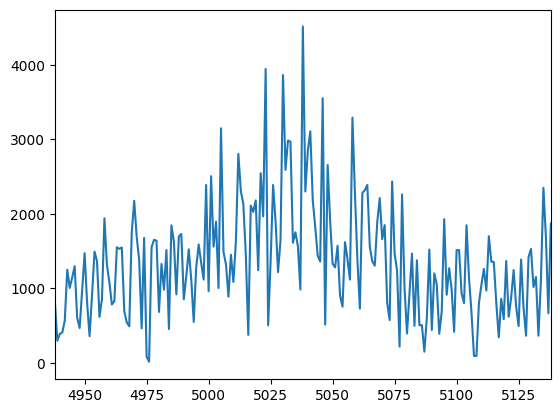

In [50]:
#take an fft to see which value to try.
xc_fft = np.fft.fftshift(np.abs(np.fft.fft(xc_small))) # should peak at -ve freq cause deltat is 2.5e-4, and fft is exp(-jomega t)
mm=np.argmax(xc_fft)
plt.plot(xc_fft)
plt.xlim(mm-100,mm+100)
M=len(xc_fft)
print(M)
print("Max at", mm-len(xc_fft)/2)
expected_delta = (mm-M/2)/M * (4096/1834)
print("Expected delta=", expected_delta)

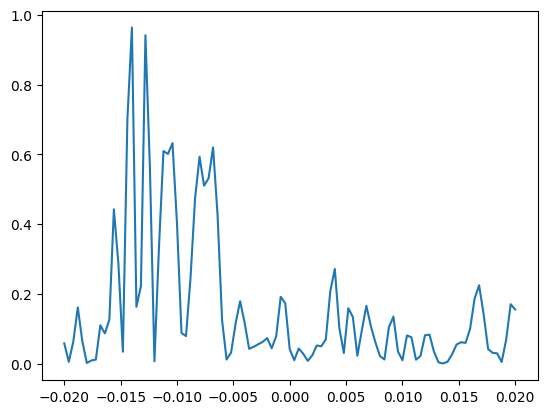

In [45]:
alphas=np.linspace(-2e-2,2e-2,101)
f_alpha = np.zeros(len(alphas))
for i in range(len(f_alpha)):
    f_alpha[i] = objective_func(xc_small,alphas[i],1834)
plt.plot(alphas,f_alpha)

In [42]:
alpha=expected_delta
for i in range(10):
    alpha=newton(xc_small,alpha,1834,scale=1)

old alpha 1.117e-02, df 5.953e+01, ddf -2.687e+05, step size -2.216e-04 new alpha 1.139e-02 
old alpha 1.139e-02, df -1.155e+01, ddf -3.305e+05, step size 3.495e-05 new alpha 1.135e-02 
old alpha 1.135e-02, df 1.423e-01, ddf -3.376e+05, step size -4.214e-07 new alpha 1.135e-02 
old alpha 1.135e-02, df 1.039e-05, ddf -3.376e+05, step size -3.077e-11 new alpha 1.135e-02 
old alpha 1.135e-02, df 3.153e-13, ddf -3.376e+05, step size -9.340e-19 new alpha 1.135e-02 
old alpha 1.135e-02, df 4.241e-14, ddf -3.376e+05, step size -1.256e-19 new alpha 1.135e-02 
old alpha 1.135e-02, df 4.241e-14, ddf -3.376e+05, step size -1.256e-19 new alpha 1.135e-02 
old alpha 1.135e-02, df 4.241e-14, ddf -3.376e+05, step size -1.256e-19 new alpha 1.135e-02 
old alpha 1.135e-02, df 4.241e-14, ddf -3.376e+05, step size -1.256e-19 new alpha 1.135e-02 
old alpha 1.135e-02, df 4.241e-14, ddf -3.376e+05, step size -1.256e-19 new alpha 1.135e-02 


-0.01212472255697502 33.11992819722041


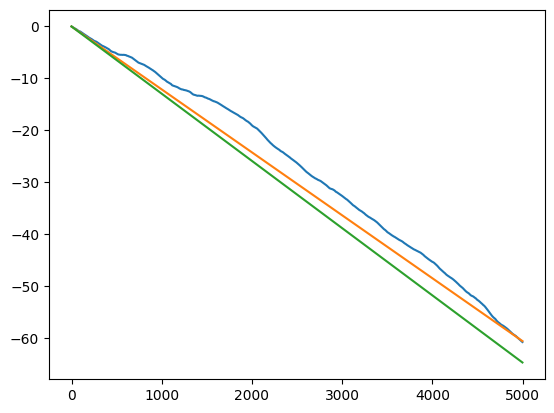

In [35]:
m,c=np.polyfit(np.arange(2500,7500),delays[2500:7500],1)
y=delays[2500:7500]
y-=y[0]
yp=m*np.arange(2500,7500)+c
yp-=yp[0]
print(m,c)
plt.plot(y)
plt.plot(yp)
plt.plot(-1.295e-2*np.arange(0,5000))

In [180]:
gain=(sol['x'][1] + 1j*sol['x'][2])
drift=sol['x'][0]
y2new=gain*y2*np.exp(2j*np.pi*1834*np.arange(0,len(y1))*drift/4096)
np.mean(y1*np.conj(y2new))

np.complex128(0.29105707444295853+5.728637574975438e-10j)

In [184]:
gain=(sol['x'][1] + 1j*sol['x'][2])
drift=sol['x'][0]
y2new=gain*y2*np.exp(2j*np.pi*1834*np.arange(0,len(y1))*drift/4096)
np.mean(y1*np.conj(y2new))

np.complex128(0.2685225597554292+1.1288029915274223e-06j)

In [164]:
y1new=y1*np.exp(-1j*np.angle(xc_small)[0])
y2new=0.1706*y2*np.exp(2j*np.pi*1834*np.arange(0,len(y1))*(-5.25e-5)/4096)
xcnew=y1new*np.conj(y2new)

In [165]:
np.mean(xcnew)

np.complex128(0.289757910717659-0.009429675114092635j)

In [167]:
np.mean(xc_small*np.exp(2j*np.pi*1834*np.arange(0,len(y1))*(5.25e-5)/4096))

np.complex128(0.1715104729854334-1.6906857595950184j)

49999


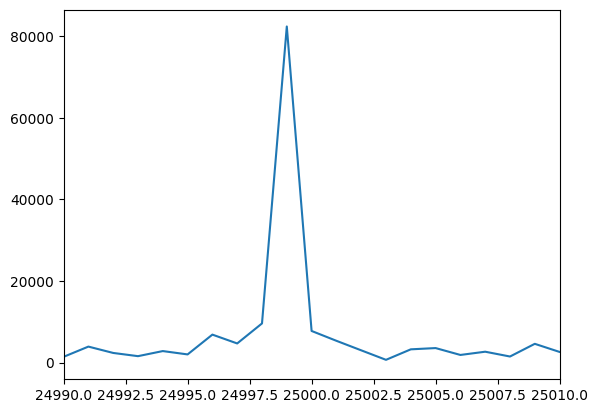

In [131]:
plt.plot(np.fft.fftshift(np.abs(xc_spec)))
plt.xlim(25000-10,25000+10)
print(np.argmax(np.abs(xc_spec)))

In [105]:
np.abs(xc_avg[0,4])

np.float64(1.5905642403477611)

In [32]:
y=np.fft.fftshift(cxcorr[0,:])[stamp].copy()

In [54]:
least_squares(model_xcorr,[1,12.],bounds=([0,0],[2,4096]),args=(y,),xtol=1e-12,jac='3-point')

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 1.280e-01 -7.726e-02 ...  2.390e-02  2.116e-02]
           x: [ 1.591e+00  1.335e+01]
        cost: 0.14890938850988636
         jac: [[-8.195e-05  1.205e-04]
               [ 9.105e-05 -1.339e-04]
               ...
               [-1.024e-04 -1.752e-04]
               [ 9.101e-05  1.557e-04]]
        grad: [-4.322e-09  3.222e-11]
  optimality: 1.7698646869647308e-09
 active_mask: [0 0]
        nfev: 8
        njev: 8

In [57]:
xc=spec1*np.conj(spec2)
avglen=10000
xc_avg=average_rows(xc,nblock=avglen)

In [68]:
cxcorr = get_coarse_xcorr(spec1[:10000,4:6], spec2[:10000,4:6])
y=np.fft.fftshift(cxcorr[0,:])[stamp].copy()

Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)


/tmp/ipykernel_1049567/393562261.py:35: RuntimeWarning: divide by zero encountered in divide
  xcorr[i, :]=xcorr[i, :]/n_avg


In [70]:
np.angle(xc_avg[0,4]),np.angle(y[dN])

(np.float64(-0.7849599189083842), np.float64(-0.784959918908385))

In [74]:
cxcorr2 = get_coarse_xcorr(spec1[10000:2*10000,4:6], spec2[10000:2*10000,4:6]*np.exp(1j*np.angle(xc_avg[0,4:6]))*np.exp(-1j*np.angle(xc_avg[1,4:6])))
y2=np.fft.fftshift(cxcorr2[0,:])[stamp].copy()

Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)


/tmp/ipykernel_1049567/393562261.py:35: RuntimeWarning: divide by zero encountered in divide
  xcorr[i, :]=xcorr[i, :]/n_avg


Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)
Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)
Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)
Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)


/tmp/ipykernel_1049567/393562261.py:35: RuntimeWarning: divide by zero encountered in divide
  xcorr[i, :]=xcorr[i, :]/n_avg
/tmp/ipykernel_1049567/393562261.py:35: RuntimeWarning: invalid value encountered in divide
  xcorr[i, :]=xcorr[i, :]/n_avg


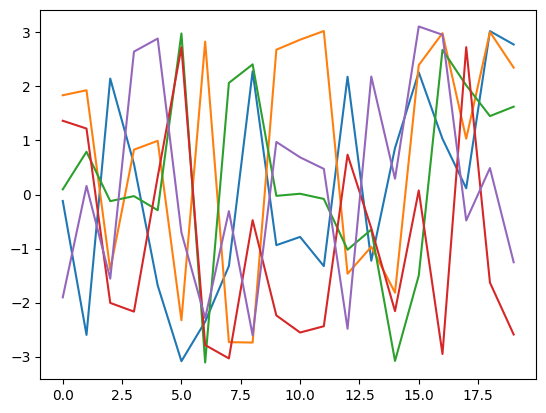

In [76]:
plt.plot(np.angle(np.fft.fftshift(cxcorr[0,:])[stamp]))
for i in range(1,xc_avg.shape[0]):
    cxcorr2 = get_coarse_xcorr(spec1[i*10000:(i+1)*10000,4:6], spec2[i*10000:(i+1)*10000,4:6]*np.exp(1j*np.angle(xc_avg[0,4:6]))*np.exp(-1j*np.angle(xc_avg[i,4:6])))
    y2=np.fft.fftshift(cxcorr2[0,:])[stamp].copy()
    plt.plot(np.angle(np.fft.fftshift(cxcorr2[0,:])[stamp]))

In [ ]:
osamp=40
xcorr_arr = np.zeros((len(k),(2*dN-1)*4096*osamp),dtype='complex128') #this is just the array to store the values
sample_no=np.arange(0,(2*dN-1)*4096*osamp)#-delay*osamp # we want values at these locations
coarse_sample_no=np.arange(0,2*dN)*4096*osamp #we have values at these locations
